In [21]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
df = pd.read_csv("spotify_songs.csv")

In [22]:
# Ta bort rader som är ointresanta
df = df.drop(columns=["track_id", "track_name", "track_popularity", "track_album_id", "track_album_name", 
                      "track_album_release_date", "playlist_id","playlist_name","playlist_subgenre","track_artist"])

In [23]:
#Converterar output från string till int
replace_dict = {
    'pop': 0,
    'rap': 1,
    'rock': 2,
    'latin': 3,
    'r&b': 4,
    'edm': 5
}
df = df.replace(replace_dict)
df["playlist_genre"] = df["playlist_genre"].astype(int)

C:\Users\tobia\AppData\Local\Temp\ipykernel_3700\1671782231.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(replace_dict)


In [24]:
#Ser till att loudness är posetiv
df["loudness"] = df["loudness"].add(100)

In [25]:
print(df.head())

   playlist_genre  danceability  energy  key  loudness  mode  speechiness  \
0               0         0.748   0.916    6    97.366     1       0.0583   
1               0         0.726   0.815   11    95.031     1       0.0373   
2               0         0.675   0.931    1    96.568     0       0.0742   
3               0         0.718   0.930    7    96.222     1       0.1020   
4               0         0.650   0.833    1    95.328     1       0.0359   

   acousticness  instrumentalness  liveness  valence    tempo  duration_ms  
0        0.1020          0.000000    0.0653    0.518  122.036       194754  
1        0.0724          0.004210    0.3570    0.693   99.972       162600  
2        0.0794          0.000023    0.1100    0.613  124.008       176616  
3        0.0287          0.000009    0.2040    0.277  121.956       169093  
4        0.0803          0.000000    0.0833    0.725  123.976       189052  


In [26]:
print(df.describe(include='all'))
print(df.shape)

       playlist_genre  danceability        energy           key      loudness  \
count    32833.000000  32833.000000  32833.000000  32833.000000  32833.000000   
mean         2.529528      0.654850      0.698619      5.374471     93.280501   
std          1.743772      0.145085      0.180910      3.611657      2.988436   
min          0.000000      0.000000      0.000175      0.000000     53.552000   
25%          1.000000      0.563000      0.581000      2.000000     91.829000   
50%          3.000000      0.672000      0.721000      6.000000     93.834000   
75%          4.000000      0.761000      0.840000      9.000000     95.355000   
max          5.000000      0.983000      1.000000     11.000000    101.275000   

               mode   speechiness  acousticness  instrumentalness  \
count  32833.000000  32833.000000  32833.000000      32833.000000   
mean       0.565711      0.107068      0.175334          0.084747   
std        0.495671      0.101314      0.219633          0.2242

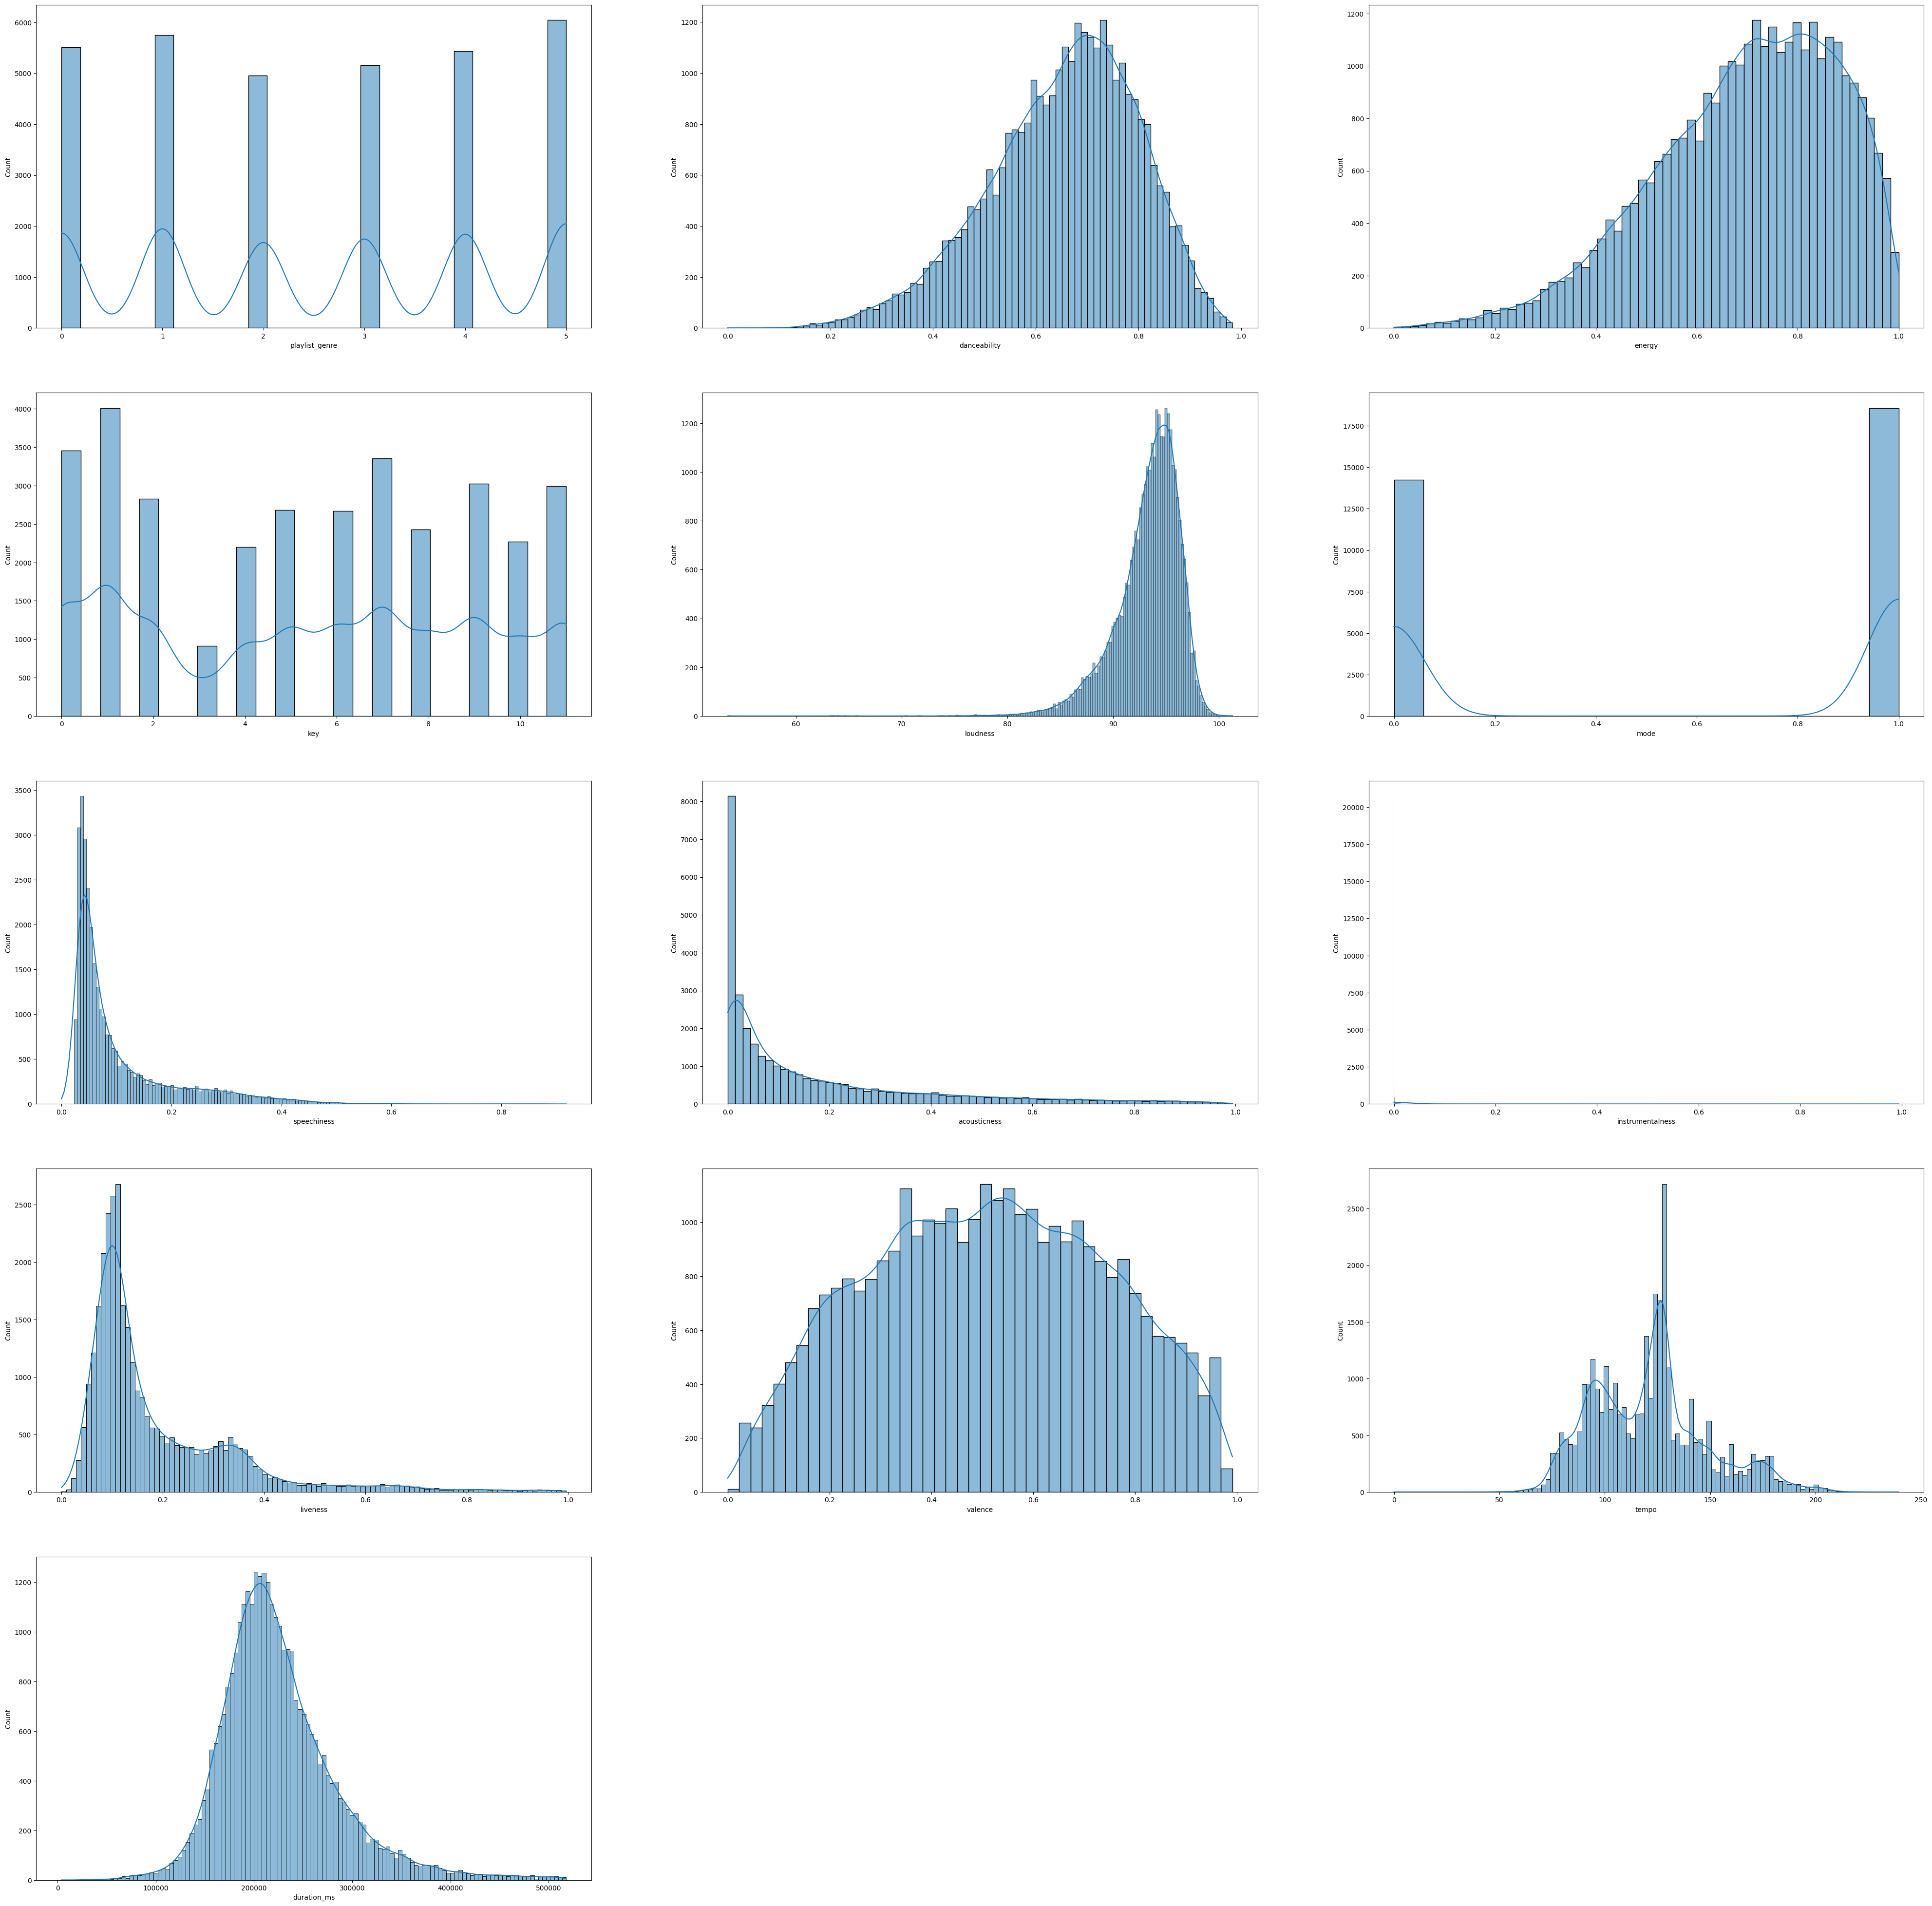

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import logging
plt.figure(figsize=(50, 50))

for i in range(1, len(df.columns) + 1):
    plt.subplot(5, 3, i)
    sns.histplot(df[df.columns[i - 1]],kde=True)

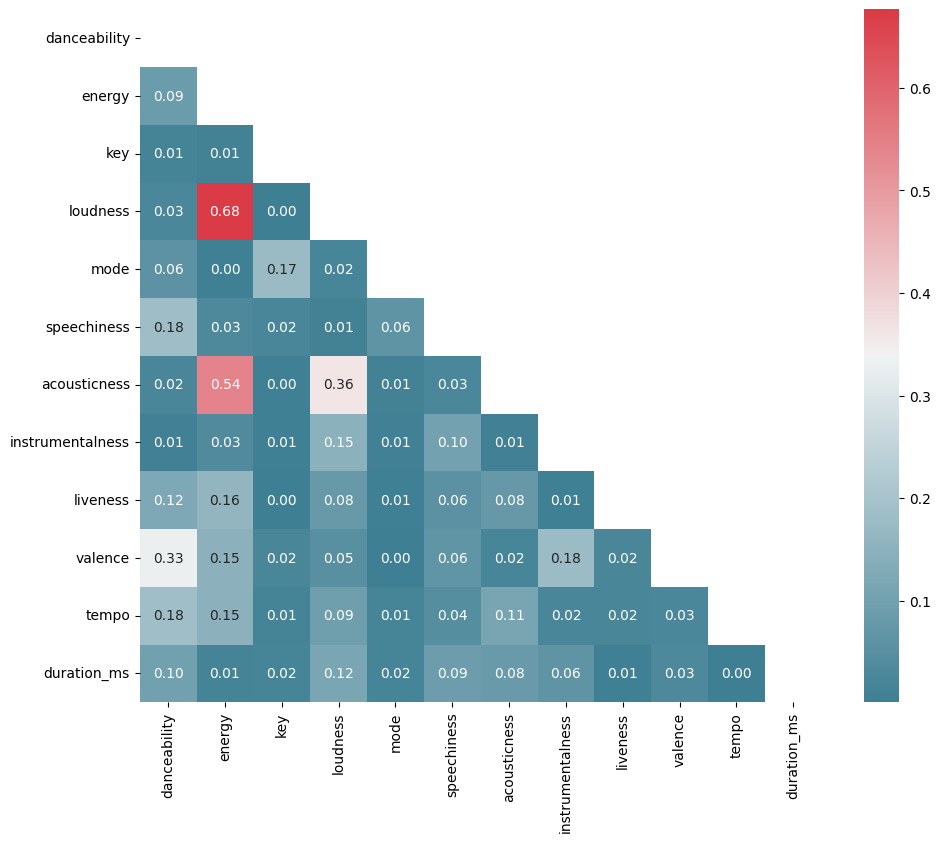

In [28]:
import numpy as np

def print_corr_heatmap(df):
    corr_df = df.corr()
    
    #corr_df.quality.abs().sort_values(ascending=False).index[0:]
    
    plt.figure(figsize=(11, 9))
    drop_self = np.zeros_like(corr_df)
    drop_self[np.triu_indices_from(drop_self)] = True
    
    sns.heatmap(corr_df.abs(), cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=drop_self)
    
print_corr_heatmap(df.drop(columns=["playlist_genre"]))

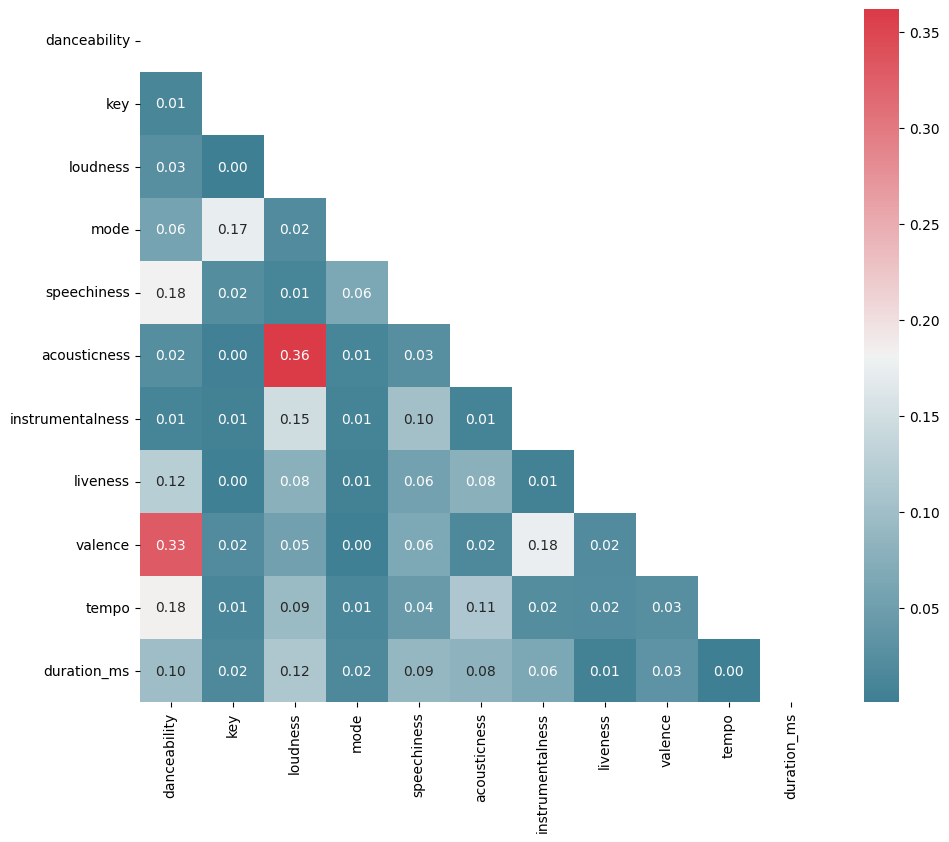

In [29]:
#energy acousticness och loudness och energy har stor corrolation så plockar bort energy, Detta hadde ingen större betydelse på slutresultatet ändå
df = df.drop(columns=["energy"])
print_corr_heatmap(df.drop(columns=["playlist_genre"]))

loudness och acousticness blir releativt hög men inte tilräkligt för att tappa all den datan, samma sak gäller valace och dancablility

In [30]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=["playlist_genre"]), df["playlist_genre"], test_size = 0.2, random_state=1)
print("Features train size:", len(x_train))
print("Features test size:", len(x_test))
results = []

Features train size: 26266
Features test size: 6567


In [31]:
#enkel proof oc consept med naive bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
clr = MultinomialNB()
clr.fit(x_train, y_train)
y_pred = clr.predict(x_test)
print("Accuracy: ", accuracy_score(y_pred, y_test))

Accuracy:  0.23892188213796253


In [32]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
# Create an instance of LinearSVC
svc_classifier = LinearSVC(C=.1, max_iter=5000,dual='auto')
# Train the classifier
svc_classifier.fit(x_train, y_train)
# Make predictions
y_pred = svc_classifier.predict(x_test)
# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
results.append({'model':"svc", 'accuracy' :accuracy})

Accuracy: 0.23739911679610173


Enligt varningarna så lyckas den inte skapa en linjär lösning även när max iter ökar så går vidare till nästa algoritm

In [33]:
#standard
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier(n_neighbors=1)  # You can adjust the number of neighbors as needed
knn_classifier.fit(x_train, y_train)  # For classification
predicted_labels = knn_classifier.predict(x_test)
accuracy = accuracy_score(y_test, predicted_labels)
print("Accuracy:", accuracy)
results.append({'model':"knn ",'neighbors':1, 'accuracy' :accuracy})

Accuracy: 0.30044160194913966


In [34]:
#ökar neigbors
knn_classifier = KNeighborsClassifier(n_neighbors=3)  # You can adjust the number of neighbors as needed
knn_classifier.fit(x_train, y_train)  # For classification
predicted_labels = knn_classifier.predict(x_test)
accuracy = accuracy_score(y_test, predicted_labels)
print("Accuracy:", accuracy)
results.append({'model':"knn 3",'neighbors':3, 'accuracy' :accuracy})

Accuracy: 0.280645652504949


In [35]:
#ökar neigbors
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors as needed
knn_classifier.fit(x_train, y_train)  # For classification
predicted_labels = knn_classifier.predict(x_test)
accuracy = accuracy_score(y_test, predicted_labels)
print("Accuracy:", accuracy)
results.append({'model':"knn 5",'neighbors':5, 'accuracy' :accuracy})

Accuracy: 0.2771432922186691


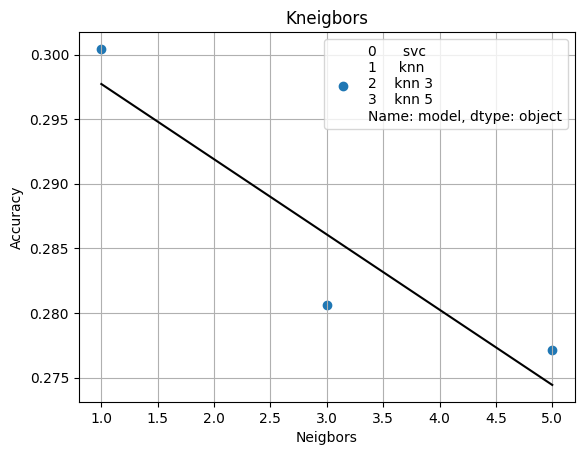

In [36]:
df = pd.DataFrame(results)
df.dropna(subset=['model'], inplace=True)
df.head(5)
dfneighbor = df.dropna(subset=['neighbors'])
plt.scatter(dfneighbor['neighbors'], dfneighbor['accuracy'], label=df['model'])
z = np.polyfit(dfneighbor['neighbors'], dfneighbor['accuracy'], 1)
p = np.poly1d(z)
plt.plot(dfneighbor['neighbors'], p(dfneighbor['neighbors']), color='black')  # Trendline

# Add labels and title
plt.xlabel('Neigbors')
plt.ylabel('Accuracy')
plt.title('Kneigbors')

# Show plot
plt.grid(True)
plt.legend()
plt.show()

1 neighbor ger bästa resultatet så kommer bli svårt att optimisera mycket längre. Dags att gå vidare till nästa algoritm  men vi har redan här dubblat slumpen så någon form av relation finns

In [37]:
#DEFAULT
from sklearn.svm import SVC
svc_classifier = SVC(kernel='rbf')  # You can choose different kernels like 'linear', 'poly', 'rbf', etc.
def svcTest(classifer,restext):
    classifer.fit(x_train, y_train)
    y_pred = classifer.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    restext["Accuracy"] = accuracy
    results.append(restext)

svcTest(svc_classifier,{'model':'svc', 'kernel':'rbf', 'c':1})

Accuracy: 0.2409014770823816


In [38]:
#100
svc_classifier = SVC(kernel='rbf',C=100)  # You can choose different kernels like 'linear', 'poly', 'rbf', etc.
svcTest(svc_classifier,{'model':'svc', 'kernel':'rbf', 'c':100})

Accuracy: 0.24227196589005634


In [39]:
#500
svc_classifier = SVC(kernel='rbf',C=500)  # You can choose different kernels like 'linear', 'poly', 'rbf', etc.
svcTest(svc_classifier,{'model':'svc', 'kernel':'rbf', 'c':500})

Accuracy: 0.24333790162935892


In [42]:
#poly 1
svc_classifier = SVC(kernel='poly',C=1)  # You can choose different kernels like 'linear', 'poly', 'rbf', etc.
svcTest(svc_classifier,{'model':'svc', 'kernel':'poly', 'c':1})

Accuracy: 0.1837977767626009


In [43]:
#poly 100
svc_classifier = SVC(kernel='poly',C=10)  # You can choose different kernels like 'linear', 'poly', 'rbf', etc.
svcTest(svc_classifier,{'model':'svc', 'kernel':'poly', 'c':10})

Accuracy: 0.1837977767626009


In [44]:
#poly 500
svc_classifier = SVC(kernel='poly',C=20)  # You can choose different kernels like 'linear', 'poly', 'rbf', etc.
svcTest(svc_classifier,{'model':'svc', 'kernel':'poly', 'c':20})

Accuracy: 0.1837977767626009


In [45]:
#sigmoid 1
svc_classifier = SVC(kernel='sigmoid',C=1)  # You can choose different kernels like 'linear', 'poly', 'rbf', etc.
svcTest(svc_classifier,{'model':'svc', 'kernel':'sigmoid', 'c':1})

Accuracy: 0.15699710674585046


In [46]:
#sigmoid 100
svc_classifier = SVC(kernel='sigmoid',C=10)  # You can choose different kernels like 'linear', 'poly', 'rbf', etc.
svcTest(svc_classifier,{'model':'svc', 'kernel':'sigmoid', 'c':10})

Accuracy: 0.1566925536774783


In [47]:
#sigmoid 500
svc_classifier = SVC(kernel='sigmoid',C=20)  # You can choose different kernels like 'linear', 'poly', 'rbf', etc.
svcTest(svc_classifier,{'model':'svc', 'kernel':'sigmoid', 'c':20})

Accuracy: 0.15684483021166437


In [48]:
print(results)

[{'model': 'svc', 'accuracy': 0.23739911679610173}, {'model': 'knn ', 'neighbors': 1, 'accuracy': 0.30044160194913966}, {'model': 'knn 3', 'neighbors': 3, 'accuracy': 0.280645652504949}, {'model': 'knn 5', 'neighbors': 5, 'accuracy': 0.2771432922186691}, {'model': 'svc', 'kernel': 'rbf', 'c': 1, 'Accuracy': 0.2409014770823816}, {'model': 'svc', 'kernel': 'rbf', 'c': 100, 'Accuracy': 0.24227196589005634}, {'model': 'svc', 'kernel': 'rbf', 'c': 500, 'Accuracy': 0.24333790162935892}, {'model': 'decisionTree', 'max_depth': 2, 'max_features': 2, 'accuracy': 0.21105527638190955}, {'model': 'decisionTree', 'max_depth': 2, 'max_features': 4, 'accuracy': 0.2661793817572712}, {'model': 'decisionTree', 'max_depth': 2, 'max_features': 8, 'accuracy': 0.2789706106289021}, {'model': 'decisionTree', 'max_depth': 2, 'max_features': 16, 'accuracy': 0.295568752855185}, {'model': 'decisionTree', 'max_depth': 2, 'max_features': 32, 'accuracy': 0.295568752855185}, {'model': 'decisionTree', 'max_depth': 2, '

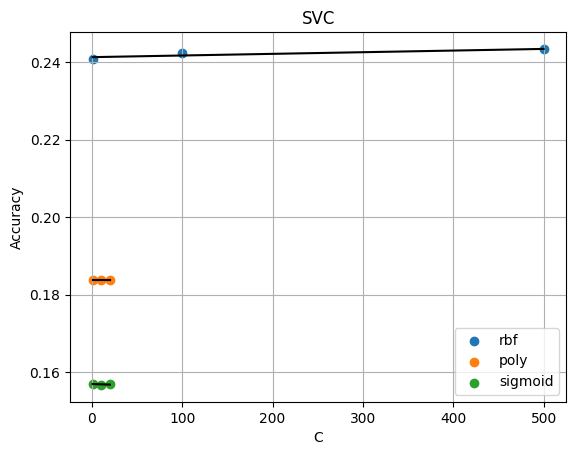

In [51]:
df = pd.DataFrame(results)
df.dropna(subset=['model'], inplace=True)
df.head(5)
# Create scatter plot
dfkern = df.dropna(subset=['kernel','c'])
unique_kernels = dfkern['kernel'].unique()
for kernel in unique_kernels:
    df_subset = dfkern[dfkern['kernel'] == kernel]
    plt.scatter(df_subset['c'], df_subset['Accuracy'], label=kernel)
    z = np.polyfit(df_subset['c'], df_subset['Accuracy'], 1)
    p = np.poly1d(z)
    plt.plot(df_subset['c'], p(df_subset['c']), color='black')  # Trendline

# Add labels and title
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('SVC')

# Show plot
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
max_depth = [2,4,8,16,32,64]
max_features = [2,4,8,16,32,64]

for depth in max_depth:
    for features in max_features:
        dt_classifier = DecisionTreeClassifier(splitter='random',random_state=5, max_features=features, max_depth=depth)
        # Train the classifier
        dt_classifier.fit(x_train, y_train)
        # Make predictions
        y_pred = dt_classifier.predict(x_test)
        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        results.append({'model':"decisionTree",'max_depth':depth,'max_features':features,'accuracy':accuracy})

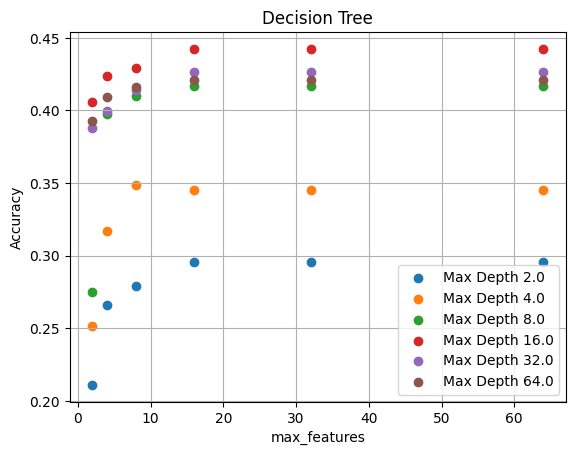

In [49]:
df = pd.DataFrame(results)
df.dropna(subset=['model'], inplace=True)
df.head(5)
#decisionTree
# Create scatter plot
dfkern = df.dropna(subset=['max_depth','max_features'])
unique_depth = dfkern['max_depth'].unique()
unique_features = dfkern['max_features'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_depth)))
#for kernel in unique_depth:
for depth in unique_depth:
    df_subset = dfkern[dfkern['max_depth'] == depth]
    plt.scatter(df_subset['max_features'], df_subset['accuracy'], label=f"Max Depth {depth}")


# Add labels and title
plt.xlabel('max_features')
plt.ylabel('Accuracy')
plt.title('Decision Tree')

# Show plot
plt.grid(True)
plt.legend()
plt.show()

In [52]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = [10,50,100,200,400,600]
max_depth = [4,8,16,32]
for est in n_estimators:
    for depth in max_depth:
        rf_classifier = RandomForestClassifier(n_estimators=est, random_state=42, max_depth=depth)
        # Train the classifier
        rf_classifier.fit(x_train, y_train)
        # Make predictions
        y_pred = rf_classifier.predict(x_test)
        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        results.append({'model':"randomForest","n_estimators":est,'accuracy':accuracy,'max_depth':depth})
    print(est)

10
50
100
200
400
600


           model  accuracy  neighbors kernel   c  Accuracy  max_depth  \
49  randomForest  0.500838        NaN    NaN NaN       NaN        4.0   
53  randomForest  0.540734        NaN    NaN NaN       NaN        4.0   
57  randomForest  0.543932        NaN    NaN NaN       NaN        4.0   
61  randomForest  0.548043        NaN    NaN NaN       NaN        4.0   
65  randomForest  0.548652        NaN    NaN NaN       NaN        4.0   

    max_features  n_estimators  
49           NaN          10.0  
53           NaN          50.0  
57           NaN         100.0  
61           NaN         200.0  
65           NaN         400.0  
           model  accuracy  neighbors kernel   c  Accuracy  max_depth  \
50  randomForest  0.500838        NaN    NaN NaN       NaN        8.0   
54  randomForest  0.540734        NaN    NaN NaN       NaN        8.0   
58  randomForest  0.543932        NaN    NaN NaN       NaN        8.0   
62  randomForest  0.548043        NaN    NaN NaN       NaN        8.0  

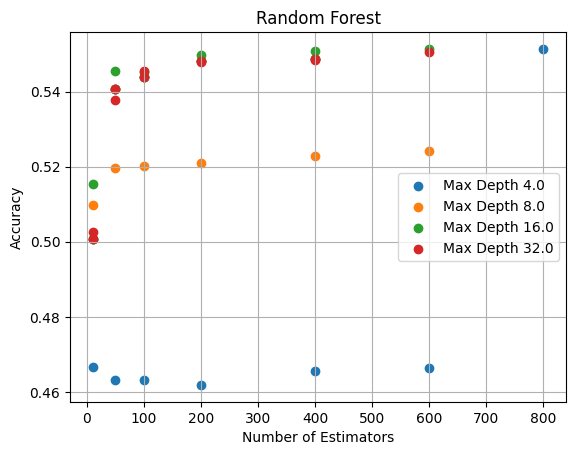

In [60]:
df = pd.DataFrame(results)
dfkern = df.dropna(subset=['max_depth','n_estimators'])
# Drop rows where 'n_estimators' column has NaN values
dfneighbor = df.dropna(subset=['n_estimators','max_depth'])
unique_depth = dfkern['max_depth'].unique()
unique_estimators = dfneighbor['n_estimators'].unique()


for depth in unique_depth:
    df_subset = dfkern[dfkern['max_depth'] == depth]
    plt.scatter(df_subset['n_estimators'], df_subset['accuracy'], label=f"Max Depth {depth}")
    z = np.polyfit(df_subset['c'], df_subset['Accuracy'], 1)
    p = np.poly1d(z)
    plt.plot(df_subset['n_estimators'], p(df_subset['n_estimators']))  # Trendline
    


# Add labels and title
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Random Forest')

# Show plot
plt.grid(True)
plt.legend()
plt.show()